In [1]:
import os
import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt

result_dir = './content/result/labels'
DATA_path = './content/DATA'

data = []

for filename in os.listdir(result_dir):

    img_filename = filename.split('.')[0] + '.bmp'
    img_dir = img_filename.split('_')[0]
    img_path = os.path.join(DATA_path, img_dir, img_filename)

    img = Image.open(img_path)
    img_width, img_height = img.size

    data_temp = dict()
    data_temp['filename'] = img_filename
    data_temp['filepath'] = img_path
    data_temp['predict'] = []

    with open(os.path.join(result_dir, filename), mode='r') as f:
        lines = f.readlines()
        for line in lines:

            temp_dict = dict()

            # for yolov5 output format
            lst = [float(a) for a in line.strip('\n').split(' ')]
            label, x_center_norm, y_center_norm, width_norm, height_norm, predict_conf = lst

            x_center = int(x_center_norm * img_width)
            y_center = int(y_center_norm * img_height)
            box_width = int(width_norm * img_width)
            box_height = int(height_norm * img_height)

            temp_dict['label'] = 'S' if label == 0 else 'others'
            temp_dict['x_center'] = x_center
            temp_dict['y_center'] = y_center
            temp_dict['box_width'] = box_width
            temp_dict['box_height'] = box_height
            temp_dict['conf'] = predict_conf

            data_temp['predict'].append(temp_dict)

    data.append(data_temp)

filename: 01990231_FILE4.bmp
No. of vertexs: 11


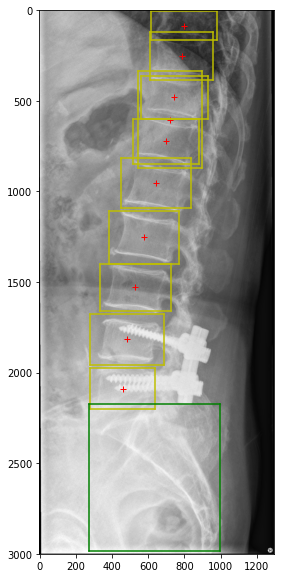

In [2]:
import random

random_id = random.randint(0, len(data)-1)

plt.figure(figsize=(10,10))
d = data[random_id]

img = Image.open(d['filepath'])
preds = d['predict']

print('filename:', d['filename'])
print('No. of vertexs:', len(preds))
plt.imshow(img, cmap='gray')

getLineStyle = {
    'S': '-g',
    'others': '-y',
}

conf_threshold = 0.2

for pred in preds:

    if pred['conf'] < conf_threshold:
        continue

    x_c, y_c = pred['x_center'], pred['y_center']
    w, h = pred['box_width'], pred['box_height']

    x_min, y_min, x_max, y_max = x_c-w/2, y_c-h/2, x_c+w/2, y_c+h/2

    style = getLineStyle[pred['label']]

    plt.plot([x_min, x_min], [y_min, y_max], style)
    plt.plot([x_max, x_max], [y_min, y_max], style)
    plt.plot([x_min, x_max], [y_min, y_min], style)
    plt.plot([x_min, x_max], [y_max, y_max], style)

    if pred['label'] != 'S':
        plt.plot(x_c, y_c, 'r+')

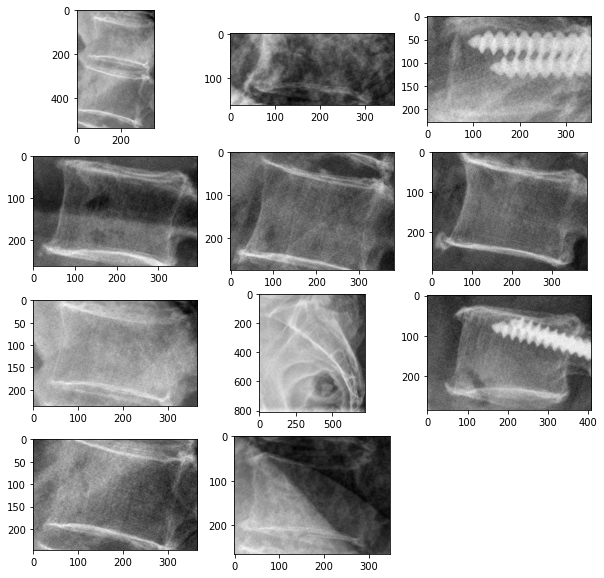

In [3]:
plt.figure(figsize=(10,10))

ncols = 3
nrows = int(len(preds)/ncols)+1

idx = 0

for pred in preds:    
    
    if pred['conf'] < conf_threshold:
        continue
    else:
        idx += 1

    x_c, y_c = pred['x_center'], pred['y_center']
    w, h = pred['box_width'], pred['box_height']

    box = (x_c-w/2, y_c-h/2, x_c+w/2, y_c+h/2)

    plt.subplot(nrows, ncols, idx)
    plt.imshow(img.crop(box), cmap='gray')